In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split as split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [30]:
df = pd.read_csv('/Maternal Health Risk Data Set.csv')
print(df.head(5))




   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


Checking null values and removing duplicates

In [31]:

df.isnull().sum()


Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [32]:
print(f"Total number of duplicates: {df.duplicated().sum()}")
df.loc[df.duplicated(keep=False)].sort_values(by=df.columns.to_list())


Total number of duplicates: 562


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
670,10,100,50,6.0,99.0,70,mid risk
849,10,100,50,6.0,99.0,70,mid risk
552,12,90,60,7.5,102.0,60,low risk
940,12,90,60,7.5,102.0,60,low risk
543,12,90,60,7.5,102.0,66,low risk
...,...,...,...,...,...,...,...
553,60,120,85,15.0,98.0,60,mid risk
772,60,120,85,15.0,98.0,60,mid risk
818,60,120,85,15.0,98.0,60,mid risk
114,63,140,90,15.0,98.0,90,high risk


UNIVARIATE ANALYSIS

Univariate analysis involves examining each variable in a dataset separately to determine its distribution, including its range of values and central tendency. Unlike bivariate and multivariate analysis, univariate data analysis does not consider relationships between variables, instead summarizing each variable independently.

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


In [34]:
def num_plot(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=df, x=col, kde=True, ax=ax[0])
    sns.boxplot(data=df, x=col, ax=ax[1])
    ax[0].set_title(f"{col} Distribution Histogram")
    ax[1].set_title(f"{col} Distribution Boxplot")

    plt.show()

Age

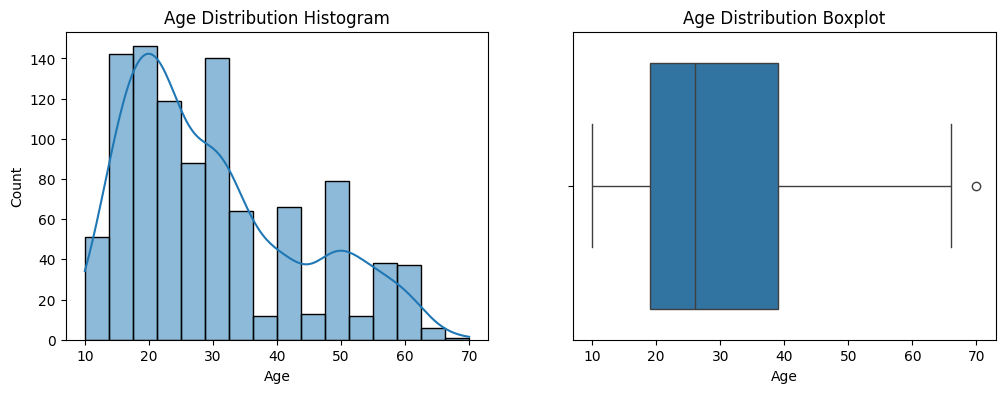

In [35]:
num_plot(df, "Age")

Systolic BP

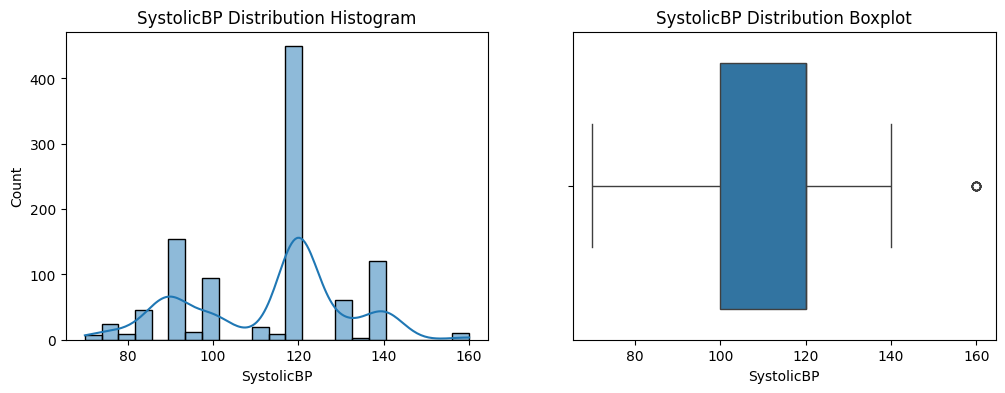

In [36]:
num_plot(df, "SystolicBP")

Diastolic BP

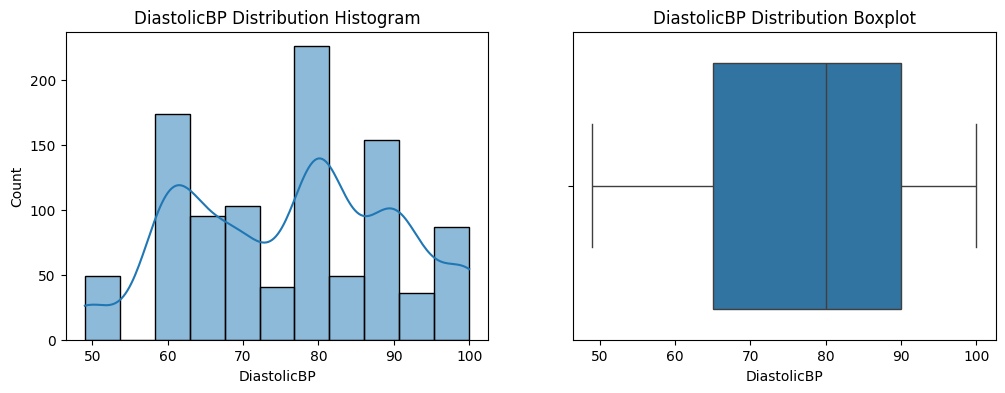

In [ ]:
num_plot(df, "DiastolicBP")

Blood Sugar

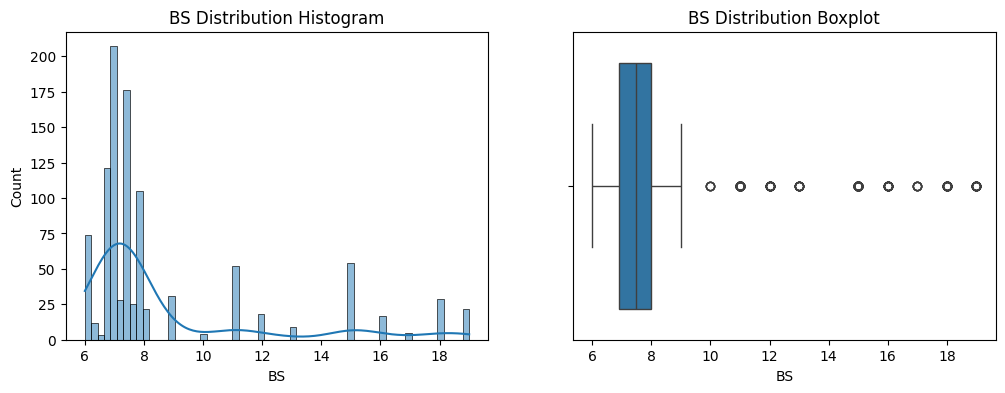

In [ ]:
num_plot(df, "BS")

Body Temperature

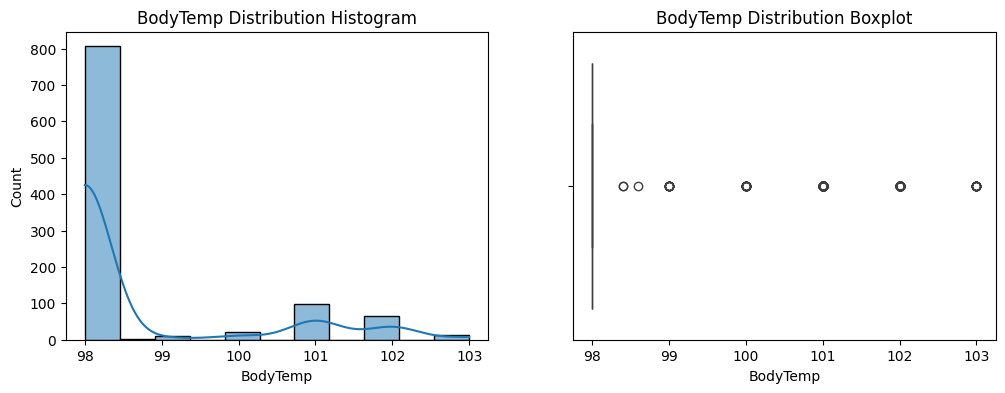

In [ ]:
num_plot(df, "BodyTemp")

Heart Rate

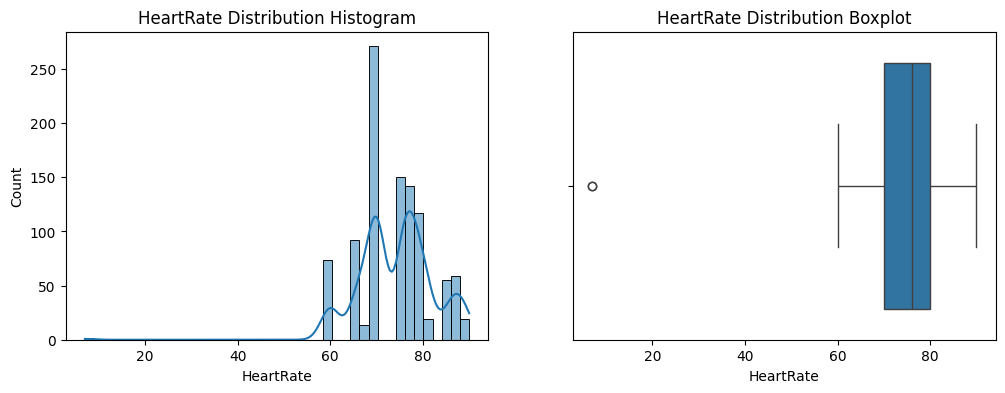

In [ ]:
num_plot(df, "HeartRate")

As we can observe- almost all variables has outlier that cause skewed distribution. HeartRate has an outlier with a value that is too far from the other values.

Categorical Variables

<ipython-input-26-859eb2061df9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  count = sns.countplot(x="RiskLevel", data=df, ax=ax[1], order=risk_order, palette=p_colors)


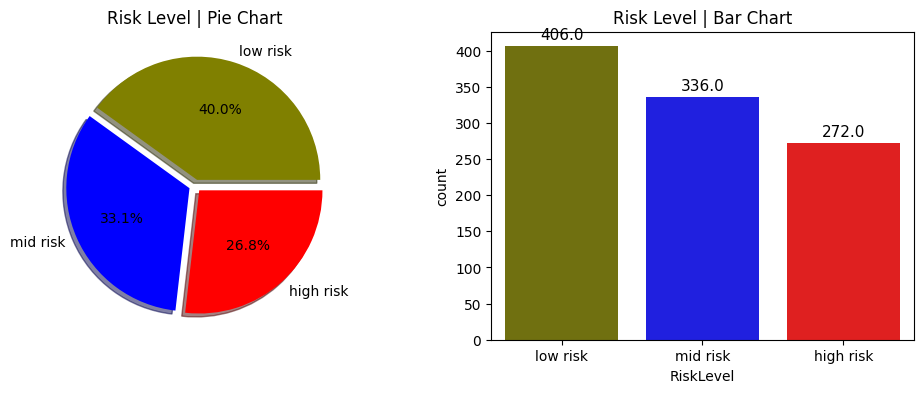

In [ ]:
p_colors = ['olive', 'blue', 'red']
risk_order = ["low risk", "mid risk", "high risk"]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

df["RiskLevel"].value_counts().plot(kind="pie", labels=risk_order, colors=p_colors, explode=[0.05, 0.05,  0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title("Risk Level | Pie Chart")
ax[0].set_ylabel('')

count = sns.countplot(x="RiskLevel", data=df, ax=ax[1], order=risk_order, palette=p_colors)
for bar in count.patches:
    count.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
ax[1].set_title("Risk Level | Bar Chart")
plt.show()

The result of the risk levels are varying due to the results shown above in the variables.


Random forest

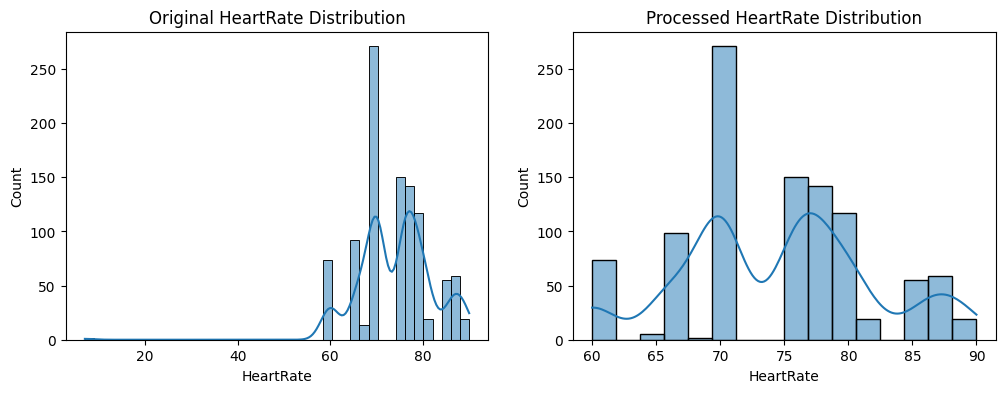

In [38]:
data_proc = df.drop(df.index[df.HeartRate == 7])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=df, x="HeartRate", kde=True, ax=ax[0])
sns.histplot(data=data_proc, x="HeartRate", kde=True, ax=ax[1])
ax[0].set_title("Original HeartRate Distribution")
ax[1].set_title("Processed HeartRate Distribution")
plt.show()

TESTED MODELS

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Original Dataset
X = df.drop("RiskLevel", axis=1)
y = df.RiskLevel
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Processed Dataset
X_proc = data_proc.drop("RiskLevel", axis=1)
y_proc = data_proc.RiskLevel
x_train_proc, x_test_proc, y_train_proc, y_test_proc = train_test_split(X_proc, y_proc, test_size=0.2, random_state=1)

print(f"Original data has {x_train.shape[0]} train data and {x_test.shape[0]} test data\n")
print(f"Processed data has {x_train_proc.shape[0]} train data and {x_test_proc.shape[0]} test data")

# Using original dataset
rf = RandomForestClassifier(random_state=100)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(f"Original Dataset Accuracy: {accuracy_score(y_test, y_pred)}")

# Using processed dataset
rf2 = RandomForestClassifier(random_state=100)
rf2.fit(x_train_proc, y_train_proc)
y_pred = rf2.predict(x_test_proc)
print(f"Processed Dataset Accuracy: {accuracy_score(y_test_proc, y_pred)}")


Original data has 760 train data and 254 test data

Processed data has 809 train data and 203 test data
Original Dataset Accuracy: 0.8582677165354331
Processed Dataset Accuracy: 0.8916256157635468


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()

# Original Dataset
X = df.drop("RiskLevel", axis=1)
y = df.RiskLevel
y_encoded = le.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=1)

# Processed Dataset
X_proc = data_proc.drop("RiskLevel", axis=1)
y_proc = data_proc.RiskLevel
y_proc_encoded = le.fit_transform(y_proc)
x_train_proc, x_test_proc, y_train_proc, y_test_proc = train_test_split(X_proc, y_proc_encoded, test_size=0.2, random_state=1)

print(f"Original data has {x_train.shape[0]} train data and {x_test.shape[0]} test data\n")
print(f"Processed data has {x_train_proc.shape[0]} train data and {x_test_proc.shape[0]} test data")

# Using original dataset with XGBoost
xgb = XGBClassifier(random_state=100)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(f"Original Dataset XGBoost Accuracy: {accuracy_score(y_test, y_pred)}")

# Using processed dataset with XGBoost
xgb2 = XGBClassifier(random_state=100)
xgb2.fit(x_train_proc, y_train_proc)
y_pred = xgb2.predict(x_test_proc)
print(f"Processed Dataset XGBoost Accuracy: {accuracy_score(y_test_proc, y_pred)}")

# Using original dataset with SVM
svm = SVC(random_state=100)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print(f"Original Dataset SVM Accuracy: {accuracy_score(y_test, y_pred)}")

# Using processed dataset with SVM
svm2 = SVC(random_state=100)
svm2.fit(x_train_proc, y_train_proc)
y_pred = svm2.predict(x_test_proc)
print(f"Processed Dataset SVM Accuracy: {accuracy_score(y_test_proc, y_pred)}")


Original data has 760 train data and 254 test data

Processed data has 809 train data and 203 test data
Original Dataset XGBoost Accuracy: 0.8385826771653543
Processed Dataset XGBoost Accuracy: 0.9014778325123153
Original Dataset SVM Accuracy: 0.6062992125984252
Processed Dataset SVM Accuracy: 0.6009852216748769
